# LayerNorm

![ln](./image/layernorm.png)

In [4]:
import torch
import torch.nn as nn
# import torch.nn as F
from torch.optim import Adam
torch.manual_seed(42)

# 训练数据和标签

In [5]:
data = torch.randn(2,3,6) 
data = torch.abs(data) # 将所有数据都放置到第一象限
label = torch.tensor([[0,1,0], [1,1,0]], dtype=torch.long)
print(data)
print(data.shape)
label.view(-1)

tensor([[[1.9269, 1.4873, 0.9007, 2.1055, 0.6784, 1.2345],
         [0.0431, 1.6047, 0.7521, 1.6487, 0.3925, 1.4036],
         [0.7279, 0.5594, 0.7688, 0.7624, 1.6423, 0.1596]],

        [[0.4974, 0.4396, 0.3189, 0.4245, 0.3057, 0.7746],
         [0.0349, 0.3211, 1.5736, 0.8455, 1.2742, 2.1228],
         [1.2347, 0.4879, 1.4181, 0.8963, 0.0499, 2.2667]]])

torch.Size([2, 3, 6])

tensor([0, 1, 0, 1, 1, 0])

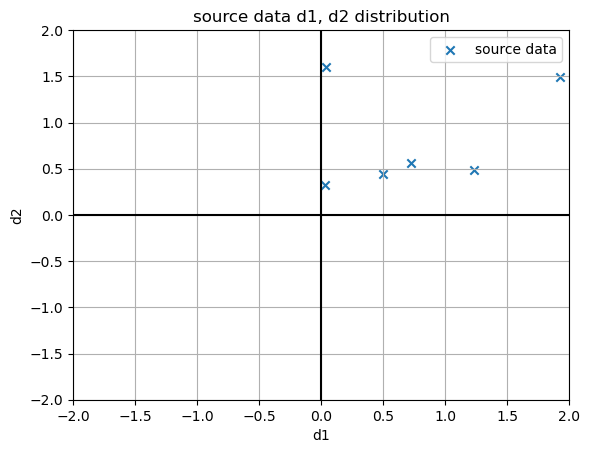

In [18]:
import matplotlib.pyplot as plt

# 仅取前两维度
plt.scatter(data.view(-1,d)[:,0].tolist(), 
            data.view(-1,d)[:,1].tolist(), 
            label='source data', 
            marker='x' ) # 原始数据
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.grid(True, which='both')
plt.axhline(y=0, color='k', linestyle='-')
plt.axvline(x=0, color='k', linestyle='-')

plt.legend()
plt.title('source data d1, d2 distribution')
plt.xlabel('d1')
plt.ylabel('d2')
plt.show()

# LayerNorm pytorch实现

In [19]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
        self.w = nn.Linear(d_model,2) # 2分类任务

    def forward(self, x):
        # layernorm作用在(-1) 最后一维进行归一化
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        out_mean_var = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out_mean_var + self.beta # feature level
        head = self.w(out)
        return mean, var, out_mean_var, out, head

# LayerNorm debug

In [8]:
dummy_data = torch.tensor([[1,2,3],[4,5,6]], dtype=torch.float32)
print('token level mean / var')
print(dummy_data.mean(-1, keepdim=True))
print(dummy_data.var(-1, unbiased=False, keepdim=True))

print('feature level Scaled & shift')
gamma = torch.tensor([1,2,3])
beta = torch.tensor([10,100,1000])
print(gamma)
gamma * dummy_data + beta

token level mean / var

tensor([[2.],
        [5.]])

tensor([[0.6667],
        [0.6667]])

feature level Scaled & shift

tensor([1, 2, 3])

tensor([[  11.,  104., 1009.],
        [  14.,  110., 1018.]])

In [9]:
b, n, d = data.shape

In [10]:
ln = LayerNorm(d)
print(ln.gamma)
print(ln.beta)

Parameter containing:
tensor([1., 1., 1., 1., 1., 1.], requires_grad=True)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

# LayerNorm 输出

In [11]:
mean, var, out_mean_var, out, pred  = ln(data)

In [12]:
print('n个数据有n个mean:\n', mean)
print('n个数据有n个var:\n', var)
print('不同数据找不同的mean和var做归一化变换：\n', out_mean_var)
print('缩放+偏移:\n', out)

n个数据有n个mean:
 tensor([[[1.3889],
         [0.9741],
         [0.7701]],

        [[0.4601],
         [1.0287],
         [1.0589]]])

n个数据有n个var:
 tensor([[[0.2633],
         [0.3819],
         [0.1966]],

        [[0.0243],
         [0.5127],
         [0.4982]]])

不同数据找不同的mean和var做归一化变换：
 tensor([[[ 1.0486,  0.1917, -0.9514,  1.3967, -1.3847, -0.3008],
         [-1.5065,  1.0203, -0.3592,  1.0916, -0.9411,  0.6950],
         [-0.0952, -0.4751, -0.0028, -0.0172,  1.9671, -1.3768]],

        [[ 0.2392, -0.1317, -0.9062, -0.2284, -0.9906,  2.0176],
         [-1.3879, -0.9882,  0.7611, -0.2559,  0.3428,  1.5281],
         [ 0.2490, -0.8090,  0.5088, -0.2304, -1.4295,  1.7112]]])

缩放+偏移:
 tensor([[[ 1.0486,  0.1917, -0.9514,  1.3967, -1.3847, -0.3008],
         [-1.5065,  1.0203, -0.3592,  1.0916, -0.9411,  0.6950],
         [-0.0952, -0.4751, -0.0028, -0.0172,  1.9671, -1.3768]],

        [[ 0.2392, -0.1317, -0.9062, -0.2284, -0.9906,  2.0176],
         [-1.3879, -0.9882,  0.7611, -0.2559,  0.3428,  1.5281],
         [ 0.2490, -0.8090,  0.5088, -0.2304, -1.4295,  1.7112]]],
       grad_fn=<AddBackward0>)

# 带LayerNorm的分类模型训练

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=ln.parameters(),)

In [20]:
ln_outputs = []
out_mean_vars = []
for i in range(1000):
    _,_,out_mean_var,ln_out,head =ln(data)
    optimizer.zero_grad()
    loss = criterion(head.view(-1, 2), label.view(-1))
    # loss = criterion(head, label)
    loss.backward()
    optimizer.step()
    if i%100 == 0:
        print(loss.mean())
    # print(out)
    ln_outputs.append(ln_out)
    out_mean_vars.append(out_mean_var)
print('不同维度的特征有不同的缩放因子和偏移')
print('layer_norm BETA: ', ln.beta)
print('layer_norm GAMMA: ', ln.gamma)

tensor(0.1044, grad_fn=<MeanBackward0>)

tensor(0.0817, grad_fn=<MeanBackward0>)

tensor(0.0651, grad_fn=<MeanBackward0>)

tensor(0.0526, grad_fn=<MeanBackward0>)

tensor(0.0432, grad_fn=<MeanBackward0>)

tensor(0.0359, grad_fn=<MeanBackward0>)

tensor(0.0302, grad_fn=<MeanBackward0>)

tensor(0.0257, grad_fn=<MeanBackward0>)

tensor(0.0220, grad_fn=<MeanBackward0>)

tensor(0.0190, grad_fn=<MeanBackward0>)

不同维度的特征有不同的缩放因子和偏移

layer_norm BETA:  Parameter containing:
tensor([ 0.0823, -0.0858,  0.4060, -0.0734, -0.7113, -0.6759],
       requires_grad=True)

layer_norm GAMMA:  Parameter containing:
tensor([1.4926, 1.3700, 2.1920, 1.8049, 2.4572, 2.5740], requires_grad=True)

# 提取前两维特征可视化

In [15]:
xy = [ item.view(-1,d) for item in ln_outputs]
x = [ tmp[:,0].tolist() for tmp in xy]
y = [ tmp[:,1].tolist() for tmp in xy]

MV_xy = [ item.view(-1,d) for item in out_mean_vars]
MV_x = [ tmp[:,0].tolist() for tmp in MV_xy]
MV_y = [ tmp[:,1].tolist() for tmp in MV_xy]

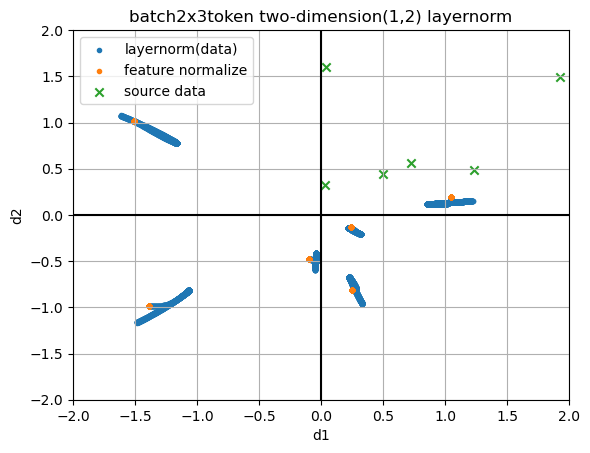

In [16]:
import matplotlib.pyplot as plt

# 仅取前两维度
plt.scatter(x, y, label='layernorm(data)', marker='.') #  laynernorm后的数据
plt.scatter(MV_x, MV_y, label='feature normalize', marker='.') #  token特征归一化的数据
plt.scatter(data.view(-1,d)[:,0].tolist(), 
            data.view(-1,d)[:,1].tolist(), 
            label='source data', 
            marker='x' ) # 原始数据
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.grid(True, which='both')
plt.axhline(y=0, color='k', linestyle='-')
plt.axvline(x=0, color='k', linestyle='-')

plt.legend()

plt.title('batch2x3token two-dimension(1,2) layernorm')
plt.xlabel('d1')
plt.ylabel('d2')

plt.show()

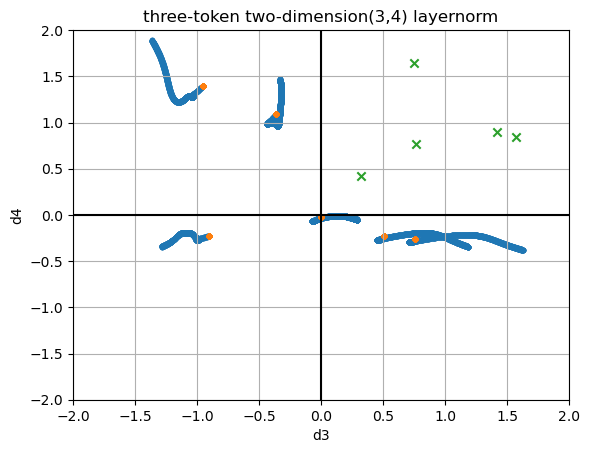

In [17]:
d1=2
d2=3

xy = [ item.view(-1,d) for item in ln_outputs]
x = [ tmp[:,d1].tolist() for tmp in xy]
y = [ tmp[:,d2].tolist() for tmp in xy]

MV_xy = [ item.view(-1,d) for item in out_mean_vars]
MV_x = [ tmp[:,d1].tolist() for tmp in MV_xy]
MV_y = [ tmp[:,d2].tolist() for tmp in MV_xy]

import matplotlib.pyplot as plt

# 仅取前两维度
plt.scatter(x, y, label='ln(data)', marker='.') #  laynernorm后的数据
plt.scatter(MV_x, MV_y, label='pre ln(data)', marker='.') #  token特征归一化的数据
plt.scatter(data.view(-1,d)[:,d1].tolist(), 
            data.view(-1,d)[:,d2].tolist(), 
            label='data', 
            marker='x' ) # 原始数据
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.grid(True, which='both')
plt.axhline(y=0, color='k', linestyle='-')
plt.axvline(x=0, color='k', linestyle='-')

plt.title('three-token two-dimension(3,4) layernorm')
plt.xlabel('d3')
plt.ylabel('d4')

plt.show()
